# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.

* **bold text**Your answer here*

1.

Accuracy is a good measure when the classes are well balanced and the cost of false positives is roughly equal to the cost of false negatives. An example would be the model that tries to determine between two animal species from wildlife camera footage. If the animal on the footage is a deer but the model predicts a rabit or the predicition fails the other way around there isn't a clear difference in costs of getting the prediction wrong.


Precision is useful in scenarios where the cost of false positives is very high. An example would be a model that tries to identify hate speech in social media posts. If the model flags non-hate speech as hate speech it could lead to censorship.

Having good recall is iportant when the cost of false negatives is very high. An example would be a model that identifies brain tumors from brain scans. If the model has bad recall and thus will regularly assess scans of tumors as non-cancerous it could have severe health consequences.

2.

Accuracy is a bad measure in situation where the frequency of one instance occuring is far greater than the other instance. This would be the case for rare diseases. The model could be accurate because it correctly identifies 97% of the population that doesn't have the disease but in the cases that matter (3% with disease) it fails even if it is accurate for the other cases.

Percision is not suitable when we want to minimize false negatives rather than false positives. An example where percsion is not suitable is a shoplifiting surveilance where the model attempts to detect shoplifing. High percision would only mean that the model can correctly identify shoplifting when it detects it but doesn't necessariy mean that it detects the majority of shoplifting.

Using recall as a measure is unsuitable when the cost of false positives is very large. This could be the case for a model that detects a rare but serious disease and additional treatment required to confirm the presence of the disease is costly. High recall would simply mean that the model is good at detecting true positive cases when they do appear but this can come at the cost of many false positives.

3.

Again a model that detects a serious disease where the cost of identifying the disease after the model flagged the individual is costly. Here both false negatives and false positives are very costly so it would be optimal to have a good F1 measure that incorperates both of these metrics.


## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

170498071/170498071 [==============================] - 3s 0us/step


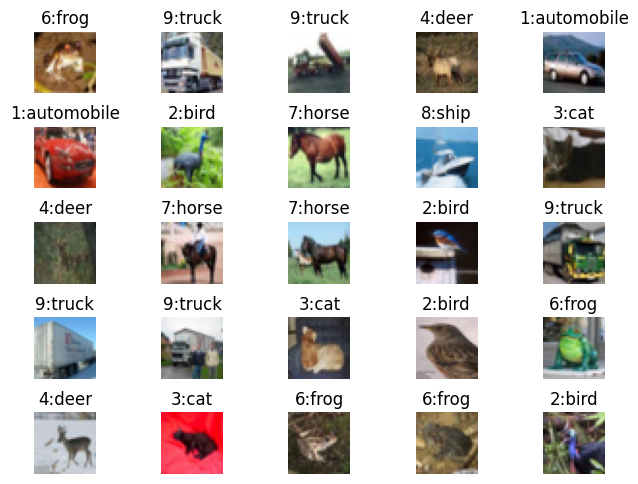

In [ ]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

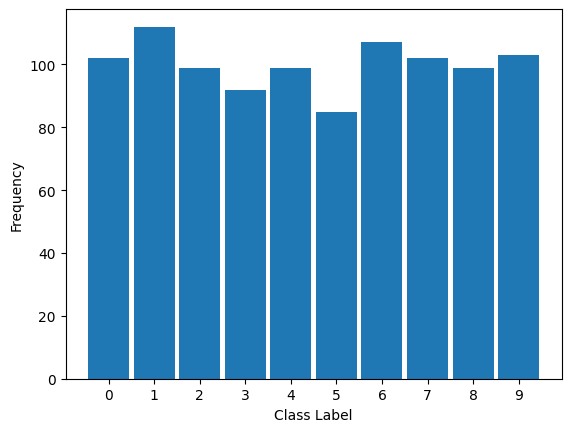

In [ ]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [ ]:
print(train_X.shape)

(1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out mean?

* 1000 denotes the number of images in the training data set. The two 32's denotes the dimension of each image. Finally the 3 denotes the three color channels (red, green and blue)

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [ ]:
# Your answer here
def flatten_cifar10(samples):
    return samples.reshape(samples.shape[0], -1)

train_X_flattened, test_X_flattened = flatten_cifar10(train_X), flatten_cifar10(test_X)

print("Number of images and features in training set:", train_X_flattened.shape)
print("Number of images and features in test set", test_X_flattened.shape)

Number of images and features in training set: (1000, 3072)
Number of images and features in test set (1000, 3072)


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [ ]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
modelLR = modelLR.fit(train_X_flattened, train_y)

train_predictions = modelLR.predict(train_X_flattened)
test_predictions = modelLR.predict(test_X_flattened)

training_accuracy = np.mean(train_predictions == train_y)
testing_accuracy = np.mean(test_predictions == test_y)

print("Training score:", training_accuracy)
print("Testing score: ", testing_accuracy)

KeyboardInterrupt: 

**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

Given that the training score equals to 1 the logisitc model fits the training data perfectly. This points towards overfitting. The fact that the testing score is far lower than the training score points towards the model not generalizing well to unseen data.

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [ ]:
from sklearn import tree
import numpy as np

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(1,16)): # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in range(10):   # loop over random initializations
        clf = tree.DecisionTreeClassifier(max_depth=d)# init new model
        clf.fit(train_X_flattened, train_y)# train model
        train_perfs.append(clf.score(train_X_flattened, train_y))# store interem values
        test_perfs.append(clf.score(test_X_flattened, test_y))

    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))


100%|██████████| 15/15 [05:05<00:00, 20.35s/it]


**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

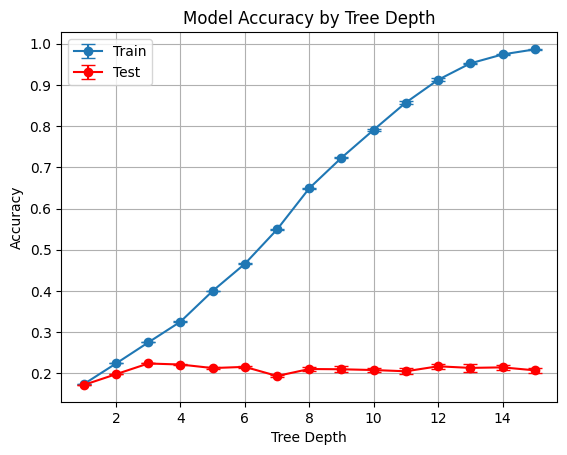

In [ ]:
import matplotlib.pyplot as plt

depths = range(1, 16)
plt.errorbar(depths, train_acc_mean, yerr=train_acc_std, label='Train', fmt='-o', capsize=5)
plt.errorbar(depths, test_acc_mean, yerr=test_acc_std, label='Test', fmt='-o', color='red', capsize=5)
plt.title('Model Accuracy by Tree Depth')
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.grid()
plt.legend()
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?

1. No the errorbars are very small which points towards very small training accuracies and thus not enough to question statistical significance.

2. The best model for the training set would be the model with depth 15 as it almost perfectly captures all the variation in the training set.

The best model for the test set is probably the model with depth 3. However, the accuracy for all the test sets is quite low and doesn't vary much.

3. Overfitting occurs at depth 3-4. The model becomes more accurate in explaining variation in the training set while not becoming any better at generalizing to unseen data.

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
import numpy as np

train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8)) # storing it in an np array instead of a list makes it easier
test_acc_mean, test_acc_std = np.zeros((10, 8)), np.zeros((10, 8))

n_trees = [n for n in range(10, 101, 10)]
depths = [d for d in range(1, 16, 2)]

for tree_idx, n_trees in enumerate(n_trees):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for n in range(5):
            clf = RFC(n_estimators=n_trees, max_depth=d, random_state=n)
            clf.fit(train_X_flattened, train_y)# train model
            train_perfs.append(clf.score(train_X_flattened, train_y))
            test_perfs.append(clf.score(test_X_flattened, test_y))# store interem values

        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

KeyboardInterrupt: 

Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

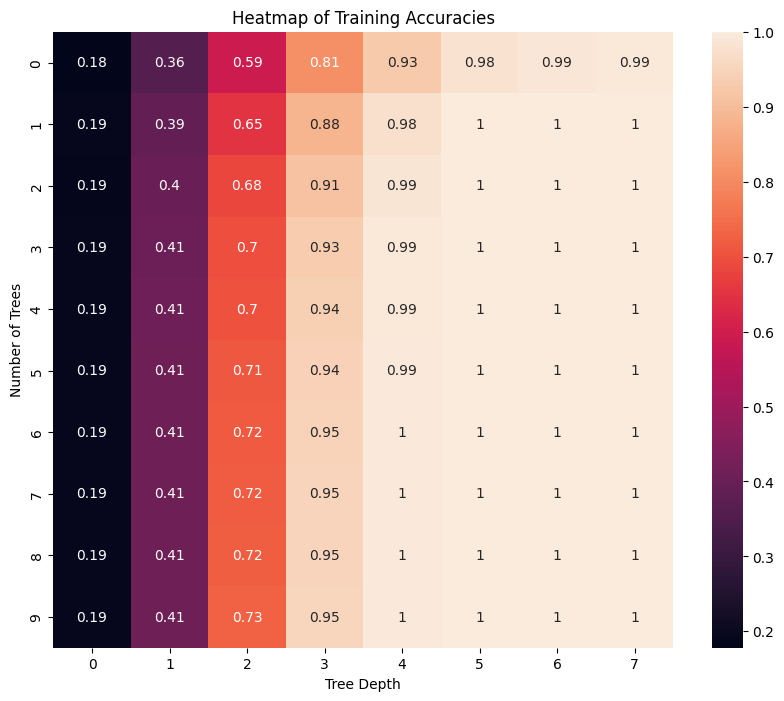

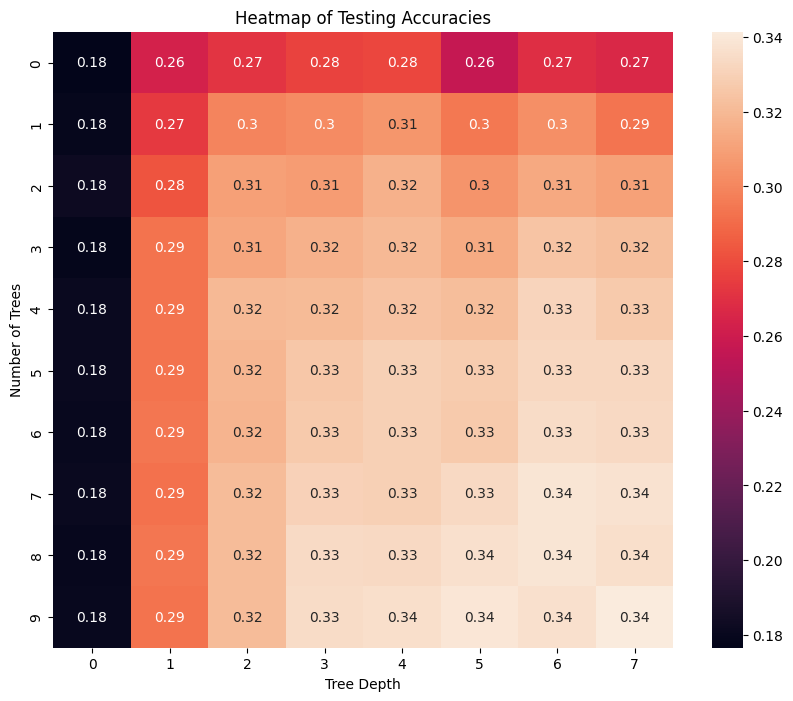

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Figure 1
plt.figure(figsize=(10, 8))
sns.heatmap(train_acc_mean, annot=True) # create seaborn heatmap with annotations
plt.xlabel('Tree Depth')# add proper xticklabels and yticklabels
plt.ylabel('Number of Trees')
plt.title('Heatmap of Training Accuracies')# add a title
plt.show()

# Figure 2
plt.figure(figsize=(10,8))
sns.heatmap(test_acc_mean, annot=True)# create seaborn heatmap with annotations
plt.xlabel('Tree Depth')# add proper xticklabels and yticklabels
plt.ylabel('Number of Trees')
plt.title('Heatmap of Testing Accuracies')# add a title
plt.show()

**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?

Training accuracies heatmap: The training accuracies increase in tree depth and reach perfect accuracy after tree depth 4. The number of trees has barely any affect on training accuracies.

Testing accuracies heatmap: The test accuracy increasese with tree depth. The testing accuracy slightly increases with the amount of trees.

2. What model performs best on the train set? What model performs best on the test set?

Training set: The optimal models are those with the highest accuracies. In the training set those are the models with tree depth above 3.

Test set: The optimal model for the test set is with at least 7 trees and where each tree has a depth of at least 5.


3. What model would you choose to deploy and why?

I would choose the model with a 9 trees and a tree depth of 1. Even though the training accuracy is quite low the discrepancy between the training accuracy and the test accuracy is lower than for the other models. This means that the model runs a lower risk of overfitting.

*Your answer here*

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm import tqdm

param_grid_svm = [
    {'kernel': ['linear','poly','rbf'],
     'C': [0.1, 1, 10, 100],
     'degree': [2, 3, 4],
     'gamma': [10**x for x in range(-2, 3)]}
]

# create the cross-validation object
optimal_params_svm = GridSearchCV(
    estimator = SVC(),             # support vector classifier instance
    param_grid =param_grid_svm,              # grid search params
    cv =5,                      # k=5 CV
    scoring='accuracy',            # use accuracy measure for best hyperparameters
)

optimal_params_svm.fit(train_X_flattened, train_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

#I can't get the code to run

**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

1.
For the linear kernel there three values and three C values thus there are 3*4=12 combinations

For the poly kernel there a 4 c values, 3 degree values and 5 gamma values thus there are 4*3*5=60 combinations

For the rbf kernel there are 4 c values and 5 gamma values thus there are 4*5=20 combinations.

In total we thus have 92 combinations

2.

92*5=460 so I trained 460 models

**Q 3.4.3**


Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [ ]:
from sklearn.svm import SVC

modelSVC = SVC(C=optimal_params_svm.best_params_['C'],
               kernel=optimal_params_svm.best_params_['kernel'],
               degree=optimal_params_svm.best_params_['degree'] if optimal_params_svm.best_params_['kernel'] == 'poly' else None,
               gamma=optimal_params_svm.best_params_['gamma']) # create model
modelSVC = fit(train_X_flattened, train_y)      # train model

train_score = modelSVC.score(train_X_flattened, train_y)
test_score = modelSVC.score(test_X_flattened, test_y)

print("Training score:", train_score)
print("Testing score: ", test_score)

#Again I pretty sure I can't get this to work if I can't get the above to work

NameError: name 'optimal_params_svm' is not defined

## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*

In [ ]:
from time import perf_counter # used to compute intervals
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm


n_train, n_test = 5000, 1000
train_X, train_y, test_X, test_y= get_data_subset(n_train, n_test) # get data
train_X_flattened = train_X.reshape((n_train, -1)) # flatten images
test_X_flattened = test_X.reshape((n_test, -1))

# set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
inf_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    start = perf_counter()               # check current (start) time
    model = model.fit(train_X, train_y)  # perform some code that you want to time
    end = perf_counter()                 # check current (end) time
    fit_time = end-start / len(train_X)                 # compute interval

    start = perf_counter()
    train_pred = model.predict(train_X)
    end = perf_counter()
    train_score_time = (end - start) / len(train_X)
    train_score = accuracy_score(train_y, train_pred)

    start = perf_counter()
    test_pred = model.predict(test_X)
    end = perf_counter()
    test_score_time = (end - start) / len(test_X)  # per image inference time
    test_score = accuracy_score(test_y, test_pred)

    return train_score, test_score, fit_time, train_score_time, test_score_time

# create models
modelLR = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
modelDT = DecisionTreeClassifier(max_depth=3)
modelRFC = RandomForestClassifier(n_estimators=9, max_depth=1)
modelSVC = SVC() #don't have an optimal parameter for this so not sure what to do

for model in tqdm([modelLR, modelDT, modelRFC, modelSVC]):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, train_X_flattened, train_y, test_X_flattened, test_y)
    train_scores.append(train_score)
    test_scores.append(test_score)
    fit_times.append(fit_time)
    inf_times.append((train_score_time, test_score_time))

for i, model in enumerate(['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC']):
    print(f"{model} - Training Accuracy: {train_scores[i]:.2f}, Test Accuracy: {test_scores[i]:.2f}, Fit Time per Image: {fit_times[i]:.6f} s/image, Train Inference Time per Image: {inf_times[i][0]:.6f} s/image, Test Inference Time per Image: {inf_times[i][1]:.6f} s/image")


Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC']
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(train_scores))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x, train_scores, bar_width, label='Training Accuracy') # training accuracy: don't forget to add labels
bar2 = ax.bar(x + bar_width, test_scores, bar_width, label='Testing Accuracy') # testing accuracy

# Add labels, title, and legend
ax.set_xlabel('model')
ax.set_ylabel('accuracy')
ax.set_title('Training and testing accuracies for each model')
# set proper x ticks: I'll help you with this one
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

In [ ]:
# Plotting the times
fig, ax = plt.subplots()
bar1 = ax.bar(...) # fit times: don't forget labels
bar2 = ax.bar(...) # inference times

# Add labels, title, and legend
# set proper x ticks

**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?




```
# This is formatted as code
```

Not sure how to answer these questions accurately if I can't manage to run the SVC model

1. The logisitic regression

2. The logisitc regression

3. I would assume the SVC model however, I cannot prove this

4. I would choose the random forest as based on the heatmap adding additional trees increases training accuracy to some extent however it should be noted that it only marginally improves the generalizability of the model. The logistic regression is less suitable for a complex data set such as this one with many non-linear relationships as can be seen by its consitently low testing accuracy. Finally I would not choose the SVC model due to its computational intensity which makes it too long to run.